In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(".."))
from ners.core.utils.data_loader import DataLoader
from ners.core.config.pipeline_config import PipelineConfig

In [22]:
config = PipelineConfig(
    paths={
        "root_dir": "../data",
        "data_dir": "../data/dataset",
        "models_dir": "../models",
        "outputs_dir": "../data/processed",
        "logs_dir": "../logs",
        "configs_dir": "../configs",
        "checkpoints_dir": "../checkpoints",
    }
)

loader = DataLoader(config)

In [36]:
gdf = gpd.read_file("../osm/provinces.shp")
gdf_proj = gdf.to_crs(epsg=32732)
gdf["centroid"] = gdf_proj.geometry.centroid.to_crs(gdf.crs)

df = loader.load_csv_complete(config.paths.data_dir / "names_featured.csv")

## Breakdown by Province

In [37]:
import unicodedata


# Helper function for cleaning province names
def clean_province(s):
    return (
        s.str.upper()
        .str.strip()
        .apply(
            lambda x: unicodedata.normalize("NFKD", x)
            .encode("ascii", errors="ignore")
            .decode("utf-8")
            if isinstance(x, str)
            else x
        )
    )


# Apply to both DataFrames
df["province"] = clean_province(df["province"])
gdf["province"] = clean_province(gdf["name"])

# Group and merge
counts = df["province"].value_counts().reset_index()
counts.columns = ["province", "count"]

gdf = gdf.merge(counts, left_on="province", right_on="province", how="left")

In [39]:
gdf.head(12)

,full_id,name,geometry,centroid,province,count
0,r5646651,Kinshasa,"POLYGON ((16.03321 -4.98926, 16.02639 -4.98868...",POINT (15.89714 -4.45276),KINSHASA,1122773
1,r193090,Bas-Congo,"POLYGON ((15.64766 -4.91155, 15.6477 -4.91174,...",POINT (14.28812 -5.2961),BAS-CONGO,268119
2,r5642699,Sud-Kivu,"POLYGON ((29.24225 -1.69991, 29.24228 -1.69991...",POINT (28.26546 -3.22633),SUD-KIVU,346152
3,r5642698,Nord-Kivu,"POLYGON ((29.39797 0.81304, 29.39806 0.81285, ...",POINT (28.70741 -0.60502),NORD-KIVU,394999
4,r5642697,Maniema,"POLYGON ((28.19331 -4.15135, 28.19369 -4.15152...",POINT (26.39038 -3.06735),MANIEMA,127813
5,r193087,Kasaï-Occidental,"POLYGON ((23.28516 -6.91736, 23.286 -6.91859, ...",POINT (21.62853 -5.4419),KASAI-OCCIDENTAL,362896
6,r193088,Kasaï-Oriental,"POLYGON ((23.28042 -7.98622, 23.28018 -7.98616...",POINT (23.94445 -4.54154),KASAI-ORIENTAL,358138
7,r3652052,Équateur,"POLYGON ((23.31621 -0.24045, 23.31099 -0.24055...",POINT (20.63056 1.02935),EQUATEUR,356404
8,r3652285,Orientale,"POLYGON ((23.08876 -0.40575, 23.08401 -0.40572...",POINT (26.42917 2.12421),ORIENTALE,317201
9,r3652335,Bandundu,"POLYGON ((20.35736 -2.19989, 20.36211 -2.20019...",POINT (18.35771 -4.37828),BANDUNDU,809949


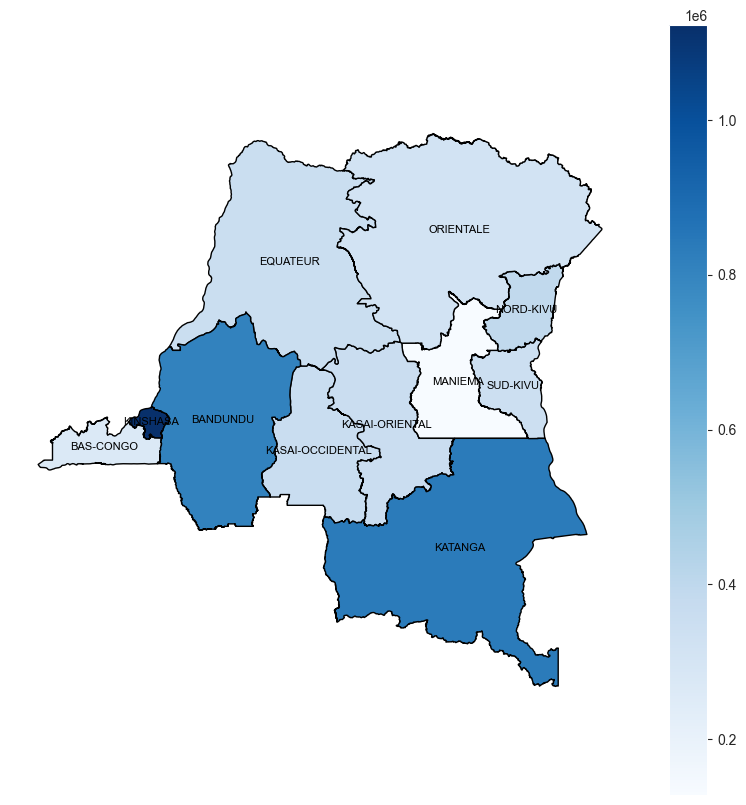

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(column="count", cmap="Blues", edgecolor="black", legend=True, ax=ax)
labels = gdf.loc[gdf["count"].notna(), ["province", "centroid"]]

for _, row in labels.iterrows():
    ax.annotate(
        text=row["province"],
        xy=(row["centroid"].x, row["centroid"].y),
        ha="center",
        va="center",
        fontsize=8,
        color="black",
    )

ax.axis("off")
plt.show()

## Distribution

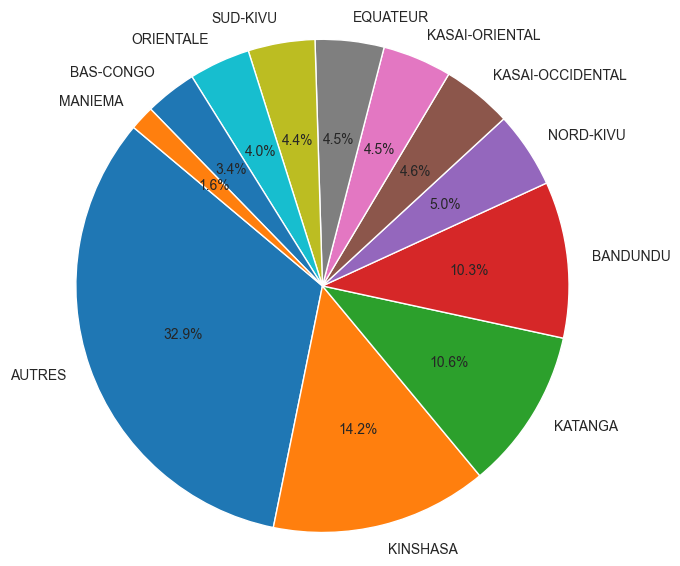

In [58]:
provinces = df["province"].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(provinces, labels=provinces.index, autopct="%1.1f%%", startangle=140)
plt.axis("equal")
plt.show()

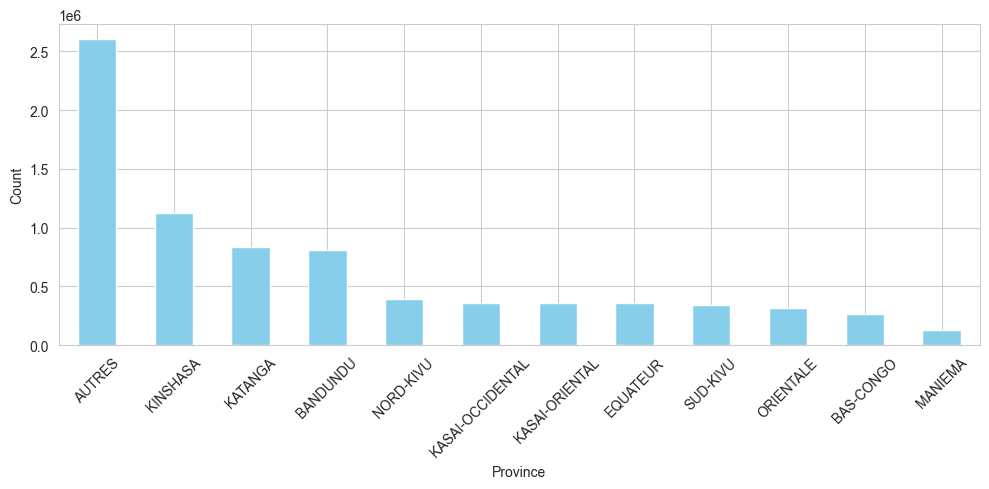

In [59]:
plt.figure(figsize=(10, 5))
provinces.plot(kind="bar", color="skyblue")
plt.xlabel("Province")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

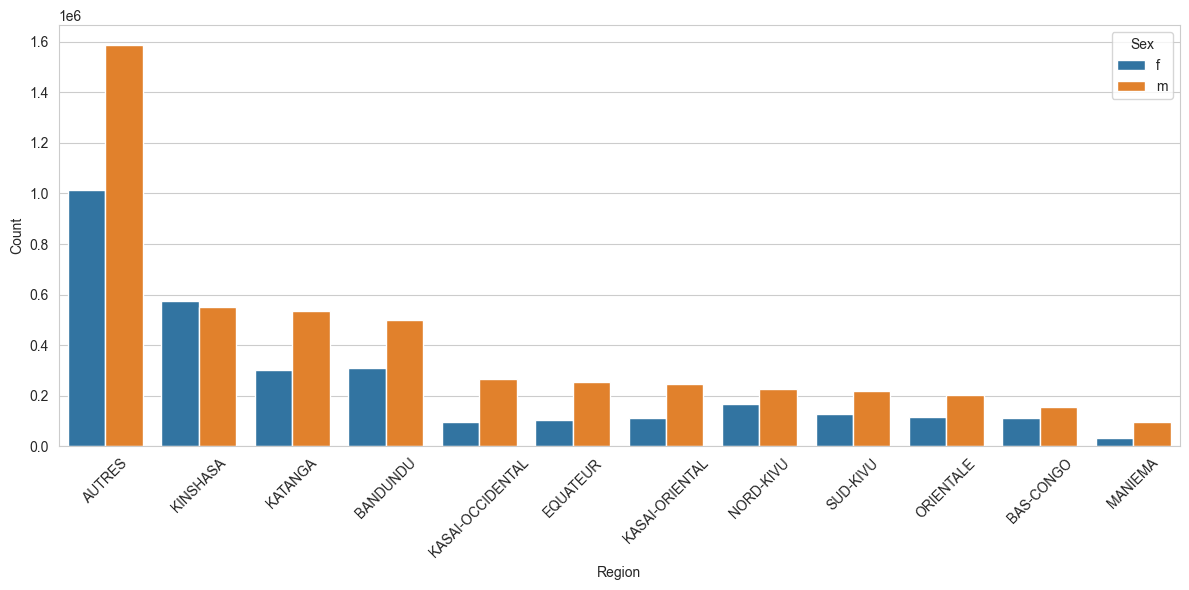

In [60]:
plt.show()
data = df.groupby(["province", "sex"], observed=False).size().reset_index(name="count")
data = data.sort_values("count", ascending=False).drop_duplicates(["province", "sex"])

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="province", y="count", hue="sex")

plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

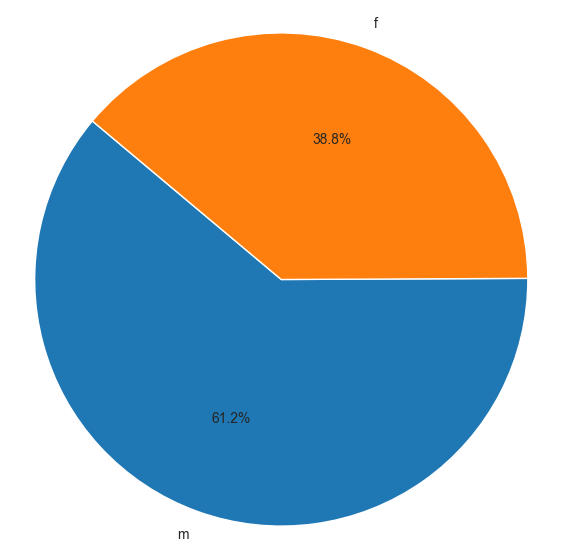

In [53]:
sex = df["sex"].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(sex, labels=sex.index, autopct="%1.1f%%", startangle=140)
plt.axis("equal")
plt.show()

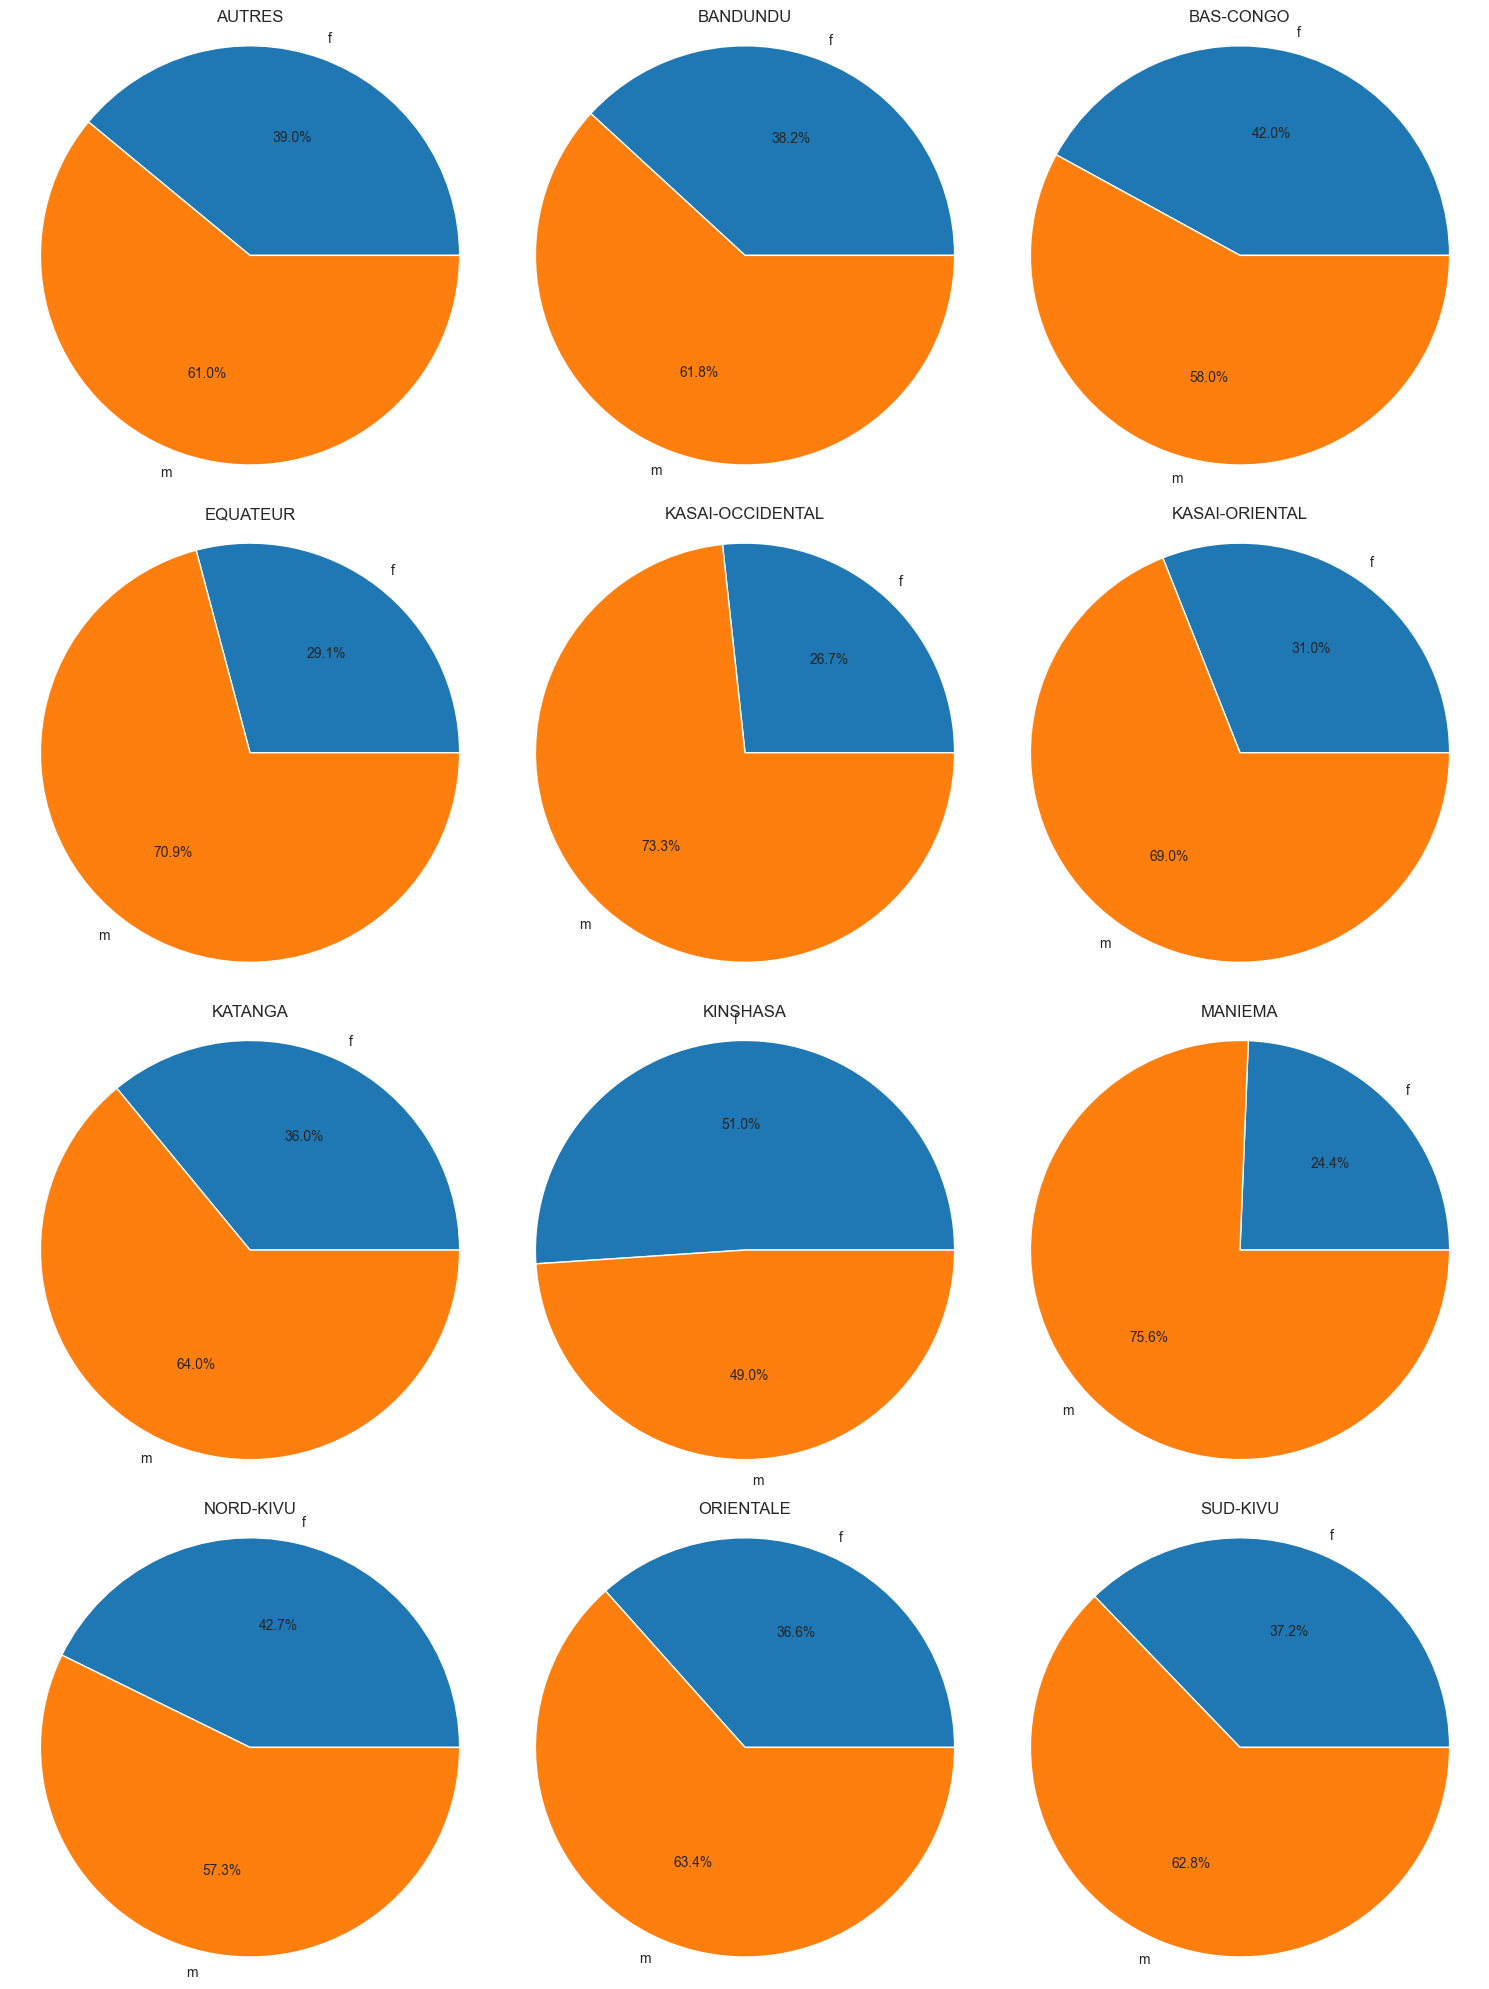

In [56]:
df_provinces_sex_counts = (
    df.groupby(["province", "sex"], observed=False).size().reset_index(name="count")
)
provinces = df_provinces_sex_counts["province"].unique()
cols = 3
rows = (len(provinces) + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 5))
for i, province in enumerate(provinces, 1):
    data = df_provinces_sex_counts[df_provinces_sex_counts["province"] == province]
    plt.subplot(rows, cols, i)
    plt.pie(data["count"], labels=data["sex"], autopct="%1.1f%%")
    plt.title(province)
    plt.axis("equal")

plt.tight_layout()
plt.show()

## Names

In [8]:
# breakdown of names into surname, middle name and first name
# retrieve all rows whose name is identified as simple, and delete rows whose identified_name is null or empty

df_simple = df[df["identified_category"] == "simple"].copy()
df_simple["surname"] = df_simple["identified_name"].str.split().str[0]
df_simple["middle_name"] = df_simple["identified_name"].str.split().str[1]
df_simple["first_name"] = df_simple["identified_surname"]
df_simple = df_simple[
    df_simple["first_name"].notna() & (df_simple["first_name"].str.strip() != "")
]

df_simple[["name", "surname", "middle_name", "first_name"]].head()

,name,surname,middle_name,first_name
0,epenge djongesongo jonas,epenge,djongesongo,jonas
1,eyongoyongo shako michel,eyongoyongo,shako,michel
2,okawonga ongondjo alphonse,okawonga,ongondjo,alphonse
3,ombala lokolo nathals,ombala,lokolo,nathals
4,shongo matete albert,shongo,matete,albert


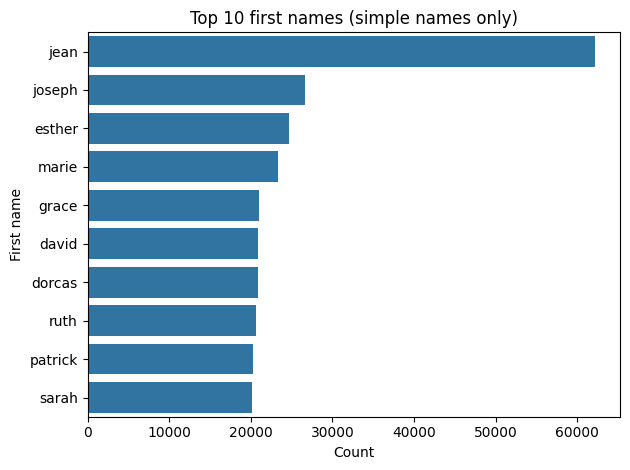

In [9]:
# Simple distribution of first names (display of the 10 most popular first names)
sns.countplot(
    y=df_simple["first_name"],
    order=df_simple["first_name"].value_counts().iloc[:10].index,
)
plt.title("Top 10 first names (simple names only)")
plt.xlabel("Count")
plt.ylabel("First name")
plt.tight_layout()
plt.show()

In [10]:
firstnames = df_simple["first_name"].value_counts()
df_firstnames = firstnames.reset_index()
df_firstnames.columns = ["First name", "quantity"]
df_firstnames.head(10)

,First name,quantity
0,jean,62143
1,joseph,26678
2,esther,24639
3,marie,23330
4,grace,20964
5,david,20909
6,dorcas,20840
7,ruth,20633
8,patrick,20209
9,sarah,20190


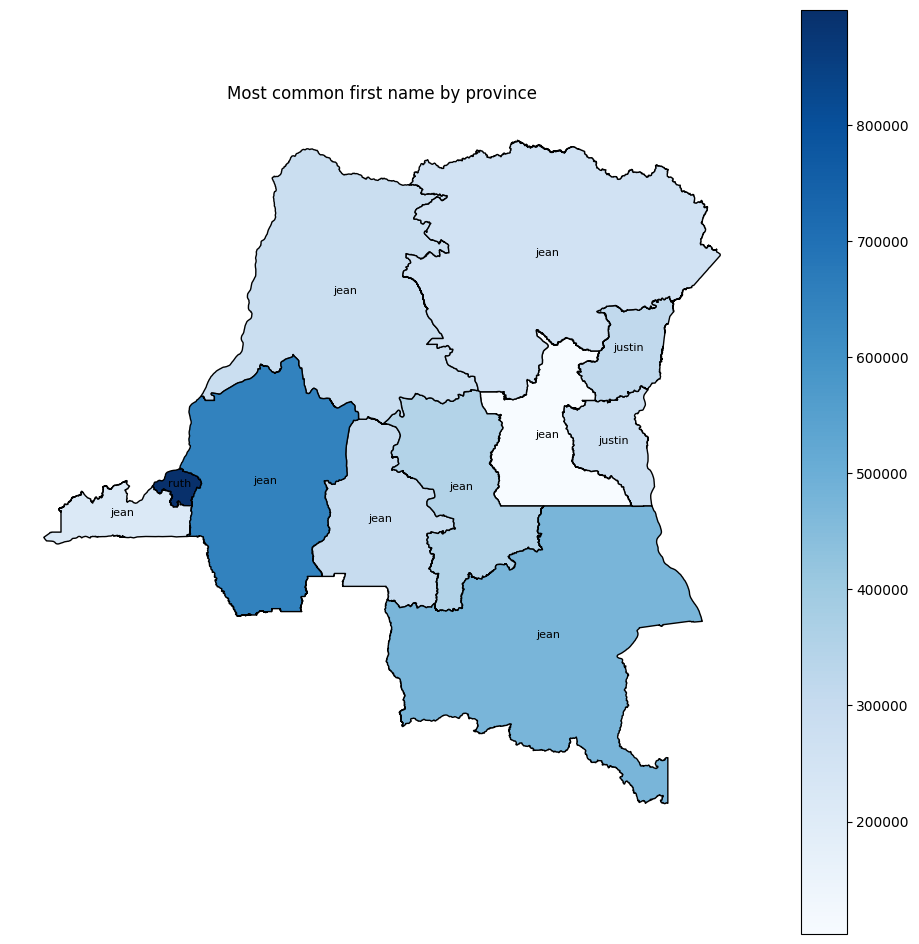

In [11]:
# Most common first name by province
top_names = (
    df_simple.groupby(["province_clean", "first_name"]).size().reset_index(name="count")
)
top_names = top_names.sort_values(["province_clean", "count"], ascending=[True, False])
top_names = top_names.drop_duplicates(subset="province_clean", keep="first")
gdf_named = gdf_merged.merge(
    top_names[["province_clean", "first_name"]],
    left_on="province_upper",
    right_on="province_clean",
    how="left",
)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column="count", cmap="Blues", edgecolor="black", legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row["first_name"]):
        centroid = row["geometry"].centroid
        label = f"{row['first_name']}"
        plt.text(
            centroid.x,
            centroid.y,
            label,
            horizontalalignment="center",
            fontsize=8,
            color="black",
        )

plt.title("Most common first name by province")
plt.axis("off")
plt.show()

In [12]:
# Total number of distinct first names
total_firstnames = df_simple["first_name"].notna().sum()
print(f">> Total number of first names registered : {total_firstnames}")

# categorization of first names
firstnames_by_sex = (
    df_simple.groupby(["first_name", "sex"]).size().unstack(fill_value=0)
)
male_firstnames = firstnames_by_sex[
    (firstnames_by_sex["m"] > 0) & (firstnames_by_sex["f"] == 0)
]
print(f">> Number of all-male first names : {len(male_firstnames)}")
female_firstnames = firstnames_by_sex[
    (firstnames_by_sex["f"] > 0) & (firstnames_by_sex["m"] == 0)
]
print(f">> Number of all-female first names : {len(female_firstnames)}")
neutral_firstnames = firstnames_by_sex[
    (firstnames_by_sex["m"] > 0) & (firstnames_by_sex["f"] > 0)
]
print(f">> Number of all-neutral first names : {len(neutral_firstnames)}")

>> Total number of first names registered : 3392438
>> Number of all-male first names : 110947
>> Number of all-female first names : 61318
>> Number of all-neutral first names : 26593


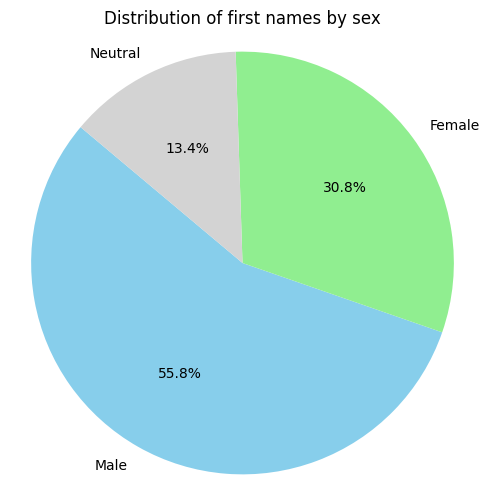

In [13]:
# data for graphic interpretation
labels = ["Male", "Female", "Neutral"]
values = [len(male_firstnames), len(female_firstnames), len(neutral_firstnames)]

# circular
plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=labels,
    autopct="%1.1f%%",
    startangle=140,
    colors=["skyblue", "lightgreen", "lightgray"],
)
plt.title("Distribution of first names by sex")
plt.axis("equal")
plt.show()

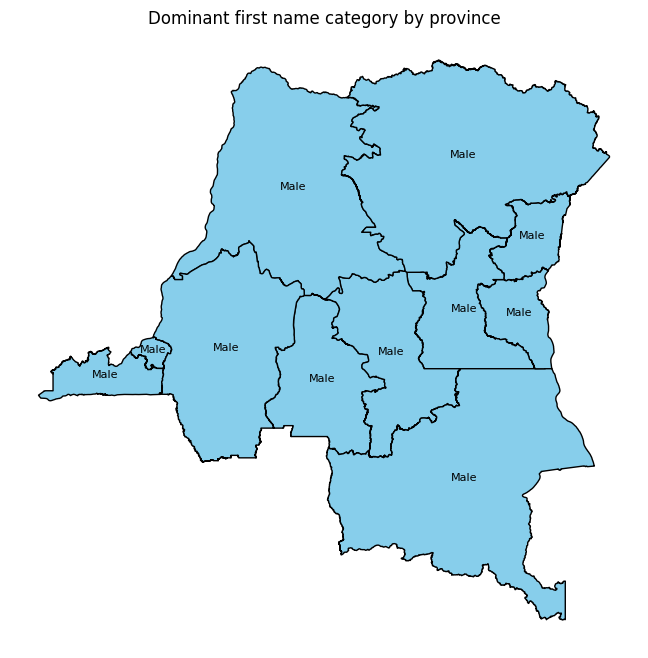

In [19]:
# Assign first name sex category
df_simple["first_name_sex_category"] = df_simple["first_name"].map(
    lambda x: "Male"
    if x in male_firstnames
    else (
        "Female"
        if x in female_firstnames
        else ("Neutral" if x in neutral_firstnames else None)
    )
)

df_cat = df_simple.dropna(subset=["first_name_sex_category"])
category_counts = (
    df_cat.groupby(["province_clean", "first_name_sex_category"])
    .size()
    .unstack(fill_value=0)
)
category_counts["dominant_category"] = category_counts.idxmax(axis=1)
map_df = gdf.set_index("province_upper").join(category_counts["dominant_category"])

color_map = {"Male": "skyblue", "Female": "lightgreen", "Neutral": "lightgray"}
map_df["color"] = map_df["dominant_category"].map(color_map)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
map_df.plot(color=map_df["color"], edgecolor="black", ax=ax)
for idx, row in map_df.iterrows():
    plt.annotate(
        text=row["dominant_category"],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        horizontalalignment="center",
        fontsize=8,
        color="black",
    )

plt.title("Dominant first name category by province")
plt.axis("off")
plt.show()

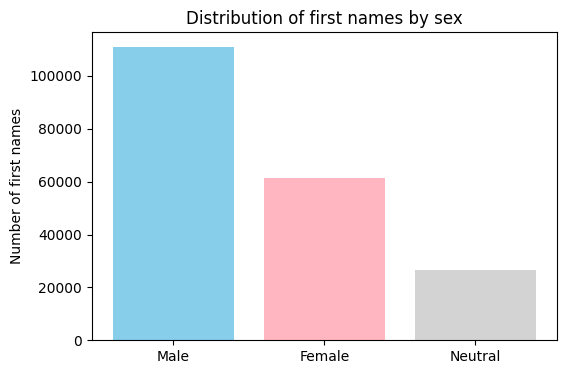

In [20]:
# Histogram
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=["skyblue", "lightpink", "lightgray"])
plt.title("Distribution of first names by sex")
plt.ylabel("Number of first names")
plt.show()

In [21]:
# Count of unique first names per region (province)
distinct_regions = df_simple["province"].nunique()
print(f">> Number of distinct regions: {distinct_regions}")
firstnames_by_region = (
    df_simple.groupby("province")["first_name"].nunique().sort_values(ascending=False)
)

print("Number of unique first names per region")
df_firstnames_region = firstnames_by_region.reset_index()
df_firstnames_region.columns = ["Region", "Unique first names"]
df_firstnames_region.head(12)

>> Number of distinct regions: 12
Number of unique first names per region


,Region,Unique first names
0,kinshasa,75509
1,bandundu,43309
2,katanga,37932
3,autres,31487
4,nord-kivu,27300
5,equateur,25389
6,bas-congo,24154
7,sud-kivu,23834
8,orientale,18356
9,kasaï-oriental,15906


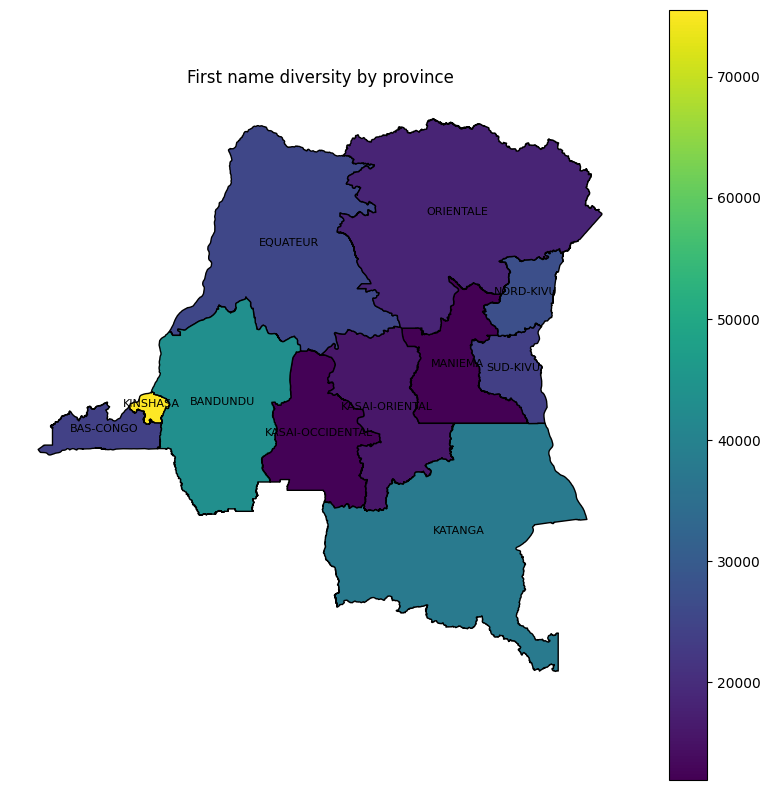

In [22]:
unique_first_names = (
    df_simple.groupby("province")["first_name"]
    .nunique()
    .reset_index(name="unique_count")
)
unique_first_names["province_clean"] = (
    unique_first_names["province"]
    .str.upper()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)
gdf_diversity = gdf_merged.merge(
    unique_first_names[["province_clean", "unique_count"]],
    on="province_clean",
    how="left",
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_diversity.plot(
    column="unique_count", cmap="viridis", edgecolor="black", legend=True, ax=ax
)

for idx, row in gdf_diversity.iterrows():
    centroid = row["geometry"].centroid
    plt.text(
        centroid.x,
        centroid.y,
        row["province_upper"],
        horizontalalignment="center",
        fontsize=8,
        color="black",
    )

plt.title("First name diversity by province")
plt.axis("off")
plt.show()

In [23]:
# top 3 most popular first names by region
grouped = df_simple.groupby(["province", "first_name"]).size().reset_index(name="count")
grouped = grouped.sort_values(["province", "count"], ascending=[True, False])
top3_by_region = grouped.groupby("province").head(3)

for province, group in top3_by_region.groupby("province"):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

AUTRES
    jean            3626
    patrick         2202
    tresor          1965

BANDUNDU
    jean            4946
    joel            1583
    marie           1163

BAS-CONGO
    jean            3380
    joseph          2090
    marie           1803

EQUATEUR
    jean            8194
    joseph          3095
    marie           2318

KASAÏ-OCCIDENTAL
    jean            10390
    andre           4787
    marie           3589

KASAÏ-ORIENTAL
    jean            14205
    joseph          5192
    marie           4772

KATANGA
    jean            5300
    ruth            3185
    esther          3018

KINSHASA
    ruth            9823
    dorcas          9801
    sarah           9696

MANIEMA
    jean            1200
    joseph          649
    marie           528

NORD-KIVU
    justin          3301
    grace           2991
    moise           2790

ORIENTALE
    jean            4447
    joseph          2755
    moise           2566

SUD-KIVU
    justin          2244
    christian     

In [25]:
# Group by region, gender and first name, then count
def determine_sex_category(row):
    if row["first_name"] in neutral_firstnames:
        return "Neutral"
    return row["sex"]


df_simple["sex_category"] = df_simple.apply(determine_sex_category, axis=1)

# Groupement
grouped = (
    df_simple.groupby(["province", "sex_category", "first_name"])
    .size()
    .reset_index(name="count")
)
grouped = grouped.sort_values(
    ["province", "sex_category", "count"], ascending=[True, True, False]
)
top3_by_region_sex = grouped.groupby(["province", "sex_category"]).head(3)

for (province, sex), group in top3_by_region_sex.groupby(["province", "sex_category"]):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

AUTRES - Neutral
    m               26
    f               4

AUTRES - f
    gracia          1257
    marie           1031
    sarah           892

AUTRES - m
    jean            3617
    patrick         2189
    tresor          1948

BANDUNDU - Neutral
    m               68
    f               27

BANDUNDU - f
    marie           1126
    ruth            1059
    esther          1053

BANDUNDU - m
    jean            4917
    joel            1539
    dieu            1118

BAS-CONGO - Neutral
    f               3
    m               2

BAS-CONGO - f
    marie           1790
    dorcas          1377
    esther          1166

BAS-CONGO - m
    jean            3369
    joseph          2082
    andre           1169

EQUATEUR - Neutral
    m               8
    f               2

EQUATEUR - f
    marie           2277
    esther          1807
    ruth            1371

EQUATEUR - m
    jean            8161
    joseph          3083
    jeremie         2243

KASAÏ-OCCIDENTAL - Neutral
    m 

In [26]:
# Grouping surnames by sex
surnames_by_sex = df_simple.groupby(["surname", "sex"]).size().reset_index(name="count")
surnames_by_sex = surnames_by_sex.sort_values(["sex", "count"], ascending=[True, False])
top10_per_sex = surnames_by_sex.groupby("sex").head(10)

for sex, group in top10_per_sex.groupby("sex"):
    print(f"Top 10 surnames for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

Top 10 surnames for sex: f
    kavira          18323
    kavugho         10909
    kahindo         10821
    ntumba          9216
    ilunga          8672
    ngalula         8446
    mbuyi           8437
    masika          8290
    mujinga         8017
    kapinga         7920

Top 10 surnames for sex: m
    ilunga          24581
    kambale         18604
    ngoy            16610
    kasongo         16420
    kasereka        12842
    muhindo         11467
    kazadi          9761
    mutombo         9262
    kakule          9179
    mumbere         8871



In [27]:
# Grouping surnames by region
surnames_by_region = (
    df_simple.groupby(["province", "surname"]).size().reset_index(name="count")
)
surnames_by_region = surnames_by_region.sort_values(
    ["province", "count"], ascending=[True, False]
)
top3_surnames_per_region = surnames_by_region.groupby("province").head(3)

for province, group in top3_surnames_per_region.groupby("province"):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

AUTRES
    ilunga          7135
    ngoy            5776
    kasongo         4363

BANDUNDU
    mbo             3479
    mpia            2408
    mputu           1777

BAS-CONGO
    nzuzi           3836
    nlandu          3292
    matondo         2796

EQUATEUR
    mboyo           1676
    lokuli          902
    bolumbu         816

KASAÏ-OCCIDENTAL
    ntumba          4999
    mbuyi           4114
    kanku           2805

KASAÏ-ORIENTAL
    ngoyi           7899
    ilunga          5223
    mbuyi           4719

KATANGA
    ilunga          15911
    ngoy            13243
    kasongo         9776

KINSHASA
    ntumba          4741
    nsimba          4470
    matondo         4382

MANIEMA
    amisi           964
    ramazani        843
    assani          596

NORD-KIVU
    kambale         17178
    kavira          17001
    kasereka        11931

ORIENTALE
    bahati          1059
    baraka          867
    kambale         849

SUD-KIVU
    bahati          2353
    furaha          

In [28]:
# Grouping surnames by region and sex
grouped = (
    df_simple.groupby(["province", "sex", "surname"]).size().reset_index(name="count")
)
grouped = grouped.sort_values(
    ["province", "sex", "count"], ascending=[True, True, False]
)
top3_surnames_by_region_sex = grouped.groupby(["province", "sex"]).head(3)

for (province, sex), group in top3_surnames_by_region_sex.groupby(["province", "sex"]):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()

AUTRES - f
    ilunga          1753
    ngoy            982
    ngoie           960

AUTRES - m
    ilunga          5382
    ngoy            4794
    kasongo         3406

BANDUNDU - f
    mbo             1207
    mpia            875
    mputu           658

BANDUNDU - m
    mbo             2272
    mpia            1533
    mputu           1119

BAS-CONGO - f
    nzuzi           2054
    nlandu          1529
    tsimba          1463

BAS-CONGO - m
    nzuzi           1782
    nlandu          1763
    ngoma           1669

EQUATEUR - f
    mboyo           796
    bolumbu         633
    amba            466

EQUATEUR - m
    mboyo           880
    lokuli          715
    lokwa           456

KASAÏ-OCCIDENTAL - f
    ngalula         2629
    kapinga         1597
    ntumba          1536

KASAÏ-OCCIDENTAL - m
    ntumba          3463
    ngalamulume     2735
    mbuyi           2666

KASAÏ-ORIENTAL - f
    ntumba          2074
    mbuyi           2023
    ngoyi           1705

KASAÏ-ORIEN

In [29]:
# Find surnames common to both sexes per region - the most popular per region

common_surnames = (
    df_simple.groupby(["province", "surname", "sex"]).size().unstack(fill_value=0)
)
common_surnames = common_surnames[
    (common_surnames.get("m", 0) > 0) & (common_surnames.get("f", 0) > 0)
]
common_surnames["total"] = common_surnames["m"] + common_surnames["f"]
common_surnames = common_surnames.reset_index()
top_common_surnames = common_surnames.sort_values(
    ["province", "total"], ascending=[True, False]
)
top_common_surnames = top_common_surnames.groupby("province").first().reset_index()

for _, row in top_common_surnames.iterrows():
    print(
        f"{row['province'].upper()} → {row['surname']} ({row['m']} M / {row['f']} F) - Total: {row['total']}"
    )

AUTRES → ilunga (5382 M / 1753 F) - Total: 7135
BANDUNDU → mbo (2272 M / 1207 F) - Total: 3479
BAS-CONGO → nzuzi (1782 M / 2054 F) - Total: 3836
EQUATEUR → mboyo (880 M / 796 F) - Total: 1676
KASAÏ-OCCIDENTAL → ntumba (3463 M / 1536 F) - Total: 4999
KASAÏ-ORIENTAL → ngoyi (6194 M / 1705 F) - Total: 7899
KATANGA → ilunga (10551 M / 5360 F) - Total: 15911
KINSHASA → ntumba (1496 M / 3245 F) - Total: 4741
MANIEMA → amisi (829 M / 135 F) - Total: 964
NORD-KIVU → kambale (17137 M / 41 F) - Total: 17178
ORIENTALE → bahati (851 M / 208 F) - Total: 1059
SUD-KIVU → bahati (1757 M / 596 F) - Total: 2353


In [30]:
# Grouping middle names by sex
middlenames_by_sex = (
    df_simple.groupby(["middle_name", "sex"]).size().reset_index(name="count")
)
middlenames_by_sex = middlenames_by_sex.sort_values(
    ["sex", "count"], ascending=[True, False]
)
top10_middlenames_per_sex = middlenames_by_sex.groupby("sex").head(10)

for sex, group in top10_middlenames_per_sex.groupby("sex"):
    print(f"Top 10 middle names for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<15} {row['count']}")
    print()

Top 10 middle names for sex: f
    ilunga          8881
    kasongo         6670
    kazadi          5320
    ngoy            5118
    ntumba          4987
    mutombo         4785
    kabeya          3752
    mukendi         3704
    matondo         3666
    ngoyi           3588

Top 10 middle names for sex: m
    ilunga          15062
    kasongo         11344
    ngoy            10703
    mutombo         8881
    kazadi          8790
    ntumba          7446
    ngoyi           7445
    kabeya          6425
    mukendi         6333
    kalala          6214



In [31]:
# Grouping middle names by region
middlenames_by_region = (
    df_simple.groupby(["province", "middle_name"]).size().reset_index(name="count")
)
middlenames_by_region = middlenames_by_region.sort_values(
    ["province", "count"], ascending=[True, False]
)
top3_middlenames_per_region = middlenames_by_region.groupby("province").head(3)

for province, group in top3_middlenames_per_region.groupby("province"):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['count']}")
    print()

AUTRES
    ngoy                 3646
    ilunga               3591
    kasongo              2761

BANDUNDU
    moke                 3243
    mbo                  1634
    mpia                 1444

BAS-CONGO
    ngoma                3570
    nlandu               2066
    khonde               1787

EQUATEUR
    mboyo                1226
    lokuli               1071
    nkoy                 724

KASAÏ-OCCIDENTAL
    ntumba               4552
    muamba               2830
    ngalamulume          2329

KASAÏ-ORIENTAL
    ngoyi                8302
    ilunga               6402
    kazadi               5260

KATANGA
    ilunga               8185
    ngoy                 8108
    kasongo              6136

KINSHASA
    matondo              3989
    ntumba               3289
    ilunga               3232

MANIEMA
    ramazani             835
    amisi                625
    shabani              525

NORD-KIVU
    tsongo               1678
    bahati               1212
    mahamba            

In [32]:
# Grouping middle names by province and sex
middlenames_by_province_sex = (
    df_simple.groupby(["province", "sex", "middle_name"])
    .size()
    .reset_index(name="count")
)
middlenames_by_province_sex = middlenames_by_province_sex.sort_values(
    ["province", "sex", "count"], ascending=[True, True, False]
)
top3_middlenames_by_province_sex = middlenames_by_province_sex.groupby(
    ["province", "sex"]
).head(3)

for (province, sex), group in top3_middlenames_by_province_sex.groupby(
    ["province", "sex"]
):
    print(f"{province.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['count']}")
    print()

AUTRES - f
    ilunga               1196
    kasongo              917
    ngoy                 824

AUTRES - m
    ngoy                 2822
    ilunga               2395
    kasongo              1844

BANDUNDU - f
    mbo                  669
    mpia                 590
    modiri               580

BANDUNDU - m
    moke                 2829
    mbo                  965
    n                    894

BAS-CONGO - f
    ngoma                1574
    nlandu               920
    khonde               797

BAS-CONGO - m
    ngoma                1996
    nlandu               1146
    muanda               999

EQUATEUR - f
    mboyo                462
    lokuli               362
    lokwa                219

EQUATEUR - m
    mboyo                764
    lokuli               709
    nkoy                 509

KASAÏ-OCCIDENTAL - f
    ntumba               1136
    muamba               679
    mulumba              597

KASAÏ-OCCIDENTAL - m
    ntumba               3416
    muamba               

In [33]:
# Find middle names common to both sexes per region
common_middlenames = (
    df_simple.groupby(["province", "middle_name", "sex"]).size().unstack(fill_value=0)
)
common_middlenames = common_middlenames[
    (common_middlenames.get("m", 0) > 0) & (common_middlenames.get("f", 0) > 0)
]
common_middlenames["total"] = common_middlenames["m"] + common_middlenames["f"]
common_middlenames = common_middlenames.reset_index()
common_middlenames = common_middlenames.sort_values(
    ["province", "total"], ascending=[True, False]
)
top3_common_middlenames = common_middlenames.groupby("province").head(3)

for province, group in top3_common_middlenames.groupby("province"):
    print(f"{province.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<20} {row['total']}")
    print()

AUTRES
    ngoy                 3646
    ilunga               3591
    kasongo              2761

BANDUNDU
    moke                 3243
    mbo                  1634
    mpia                 1444

BAS-CONGO
    ngoma                3570
    nlandu               2066
    khonde               1787

EQUATEUR
    mboyo                1226
    lokuli               1071
    nkoy                 724

KASAÏ-OCCIDENTAL
    ntumba               4552
    muamba               2830
    ngalamulume          2329

KASAÏ-ORIENTAL
    ngoyi                8302
    ilunga               6402
    kazadi               5260

KATANGA
    ilunga               8185
    ngoy                 8108
    kasongo              6136

KINSHASA
    matondo              3989
    ntumba               3289
    ilunga               3232

MANIEMA
    ramazani             835
    amisi                625
    shabani              525

NORD-KIVU
    tsongo               1678
    bahati               1212
    mahamba            

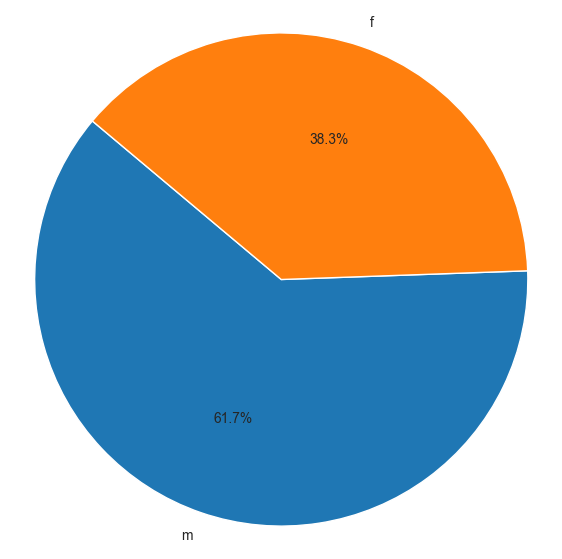

In [7]:
# Pie chart of surnames by sex
sex = df["sex"].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(sex, labels=sex.index, autopct="%1.1f%%", startangle=140)
plt.axis("equal")
plt.show()

In [11]:
table = df.groupby(["year", "sex"]).size().unstack(fill_value=0)
print(table)

sex        f       m
year                
2008   58638  105354
2009   80481  164149
2010   83388  181810
2011  102442  204793
2012  103701  209747
2013   89274  167704
2015  129413  218168
2016  142784  225395
2017  156652  244894
2018  192679  290022
2019  204459  313307
2020     961    3624
2021  190157  271851
2022  251812  352788
2023  322046  439867


/var/folders/bw/q877f1m179b8c_66m6m6x7wr0000gn/T/ipykernel_90642/1279743048.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby(["year", "sex"]).size().unstack(fill_value=0)


/var/folders/bw/q877f1m179b8c_66m6m6x7wr0000gn/T/ipykernel_90642/286407675.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df.groupby(['province', 'sex']).size().reset_index(name='count')


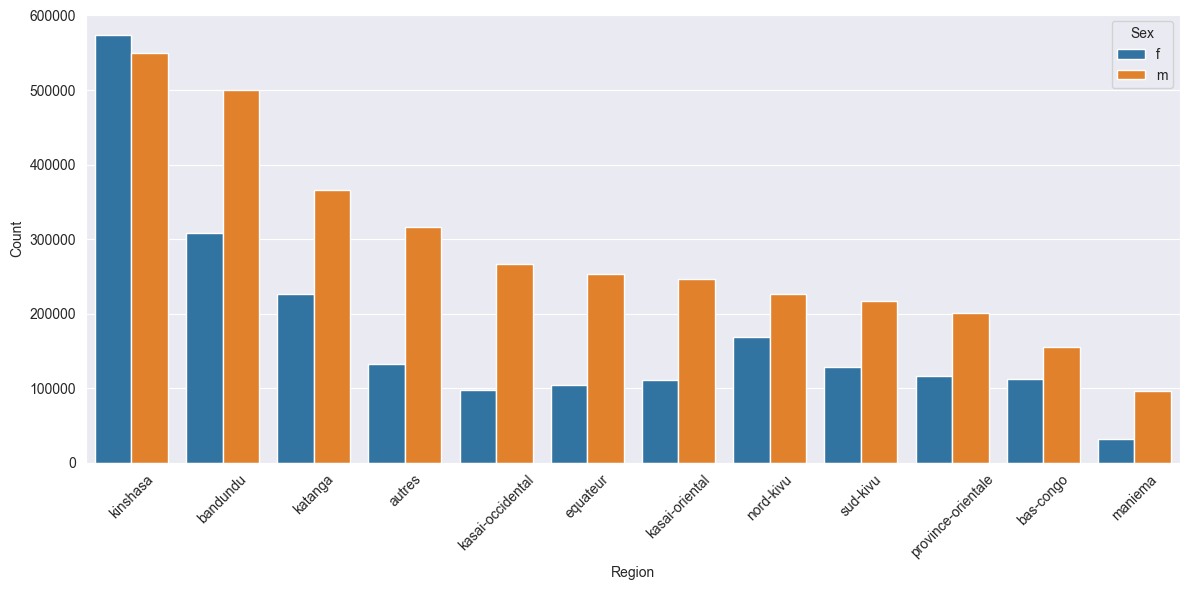

In [12]:
plt.show()
# Bar chart middle name by region and sex
data = df.groupby(["province", "sex"]).size().reset_index(name="count")
dataa = data.sort_values("count", ascending=False).drop_duplicates(["province", "sex"])

# Bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=dataa, x="province", y="count", hue="sex")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

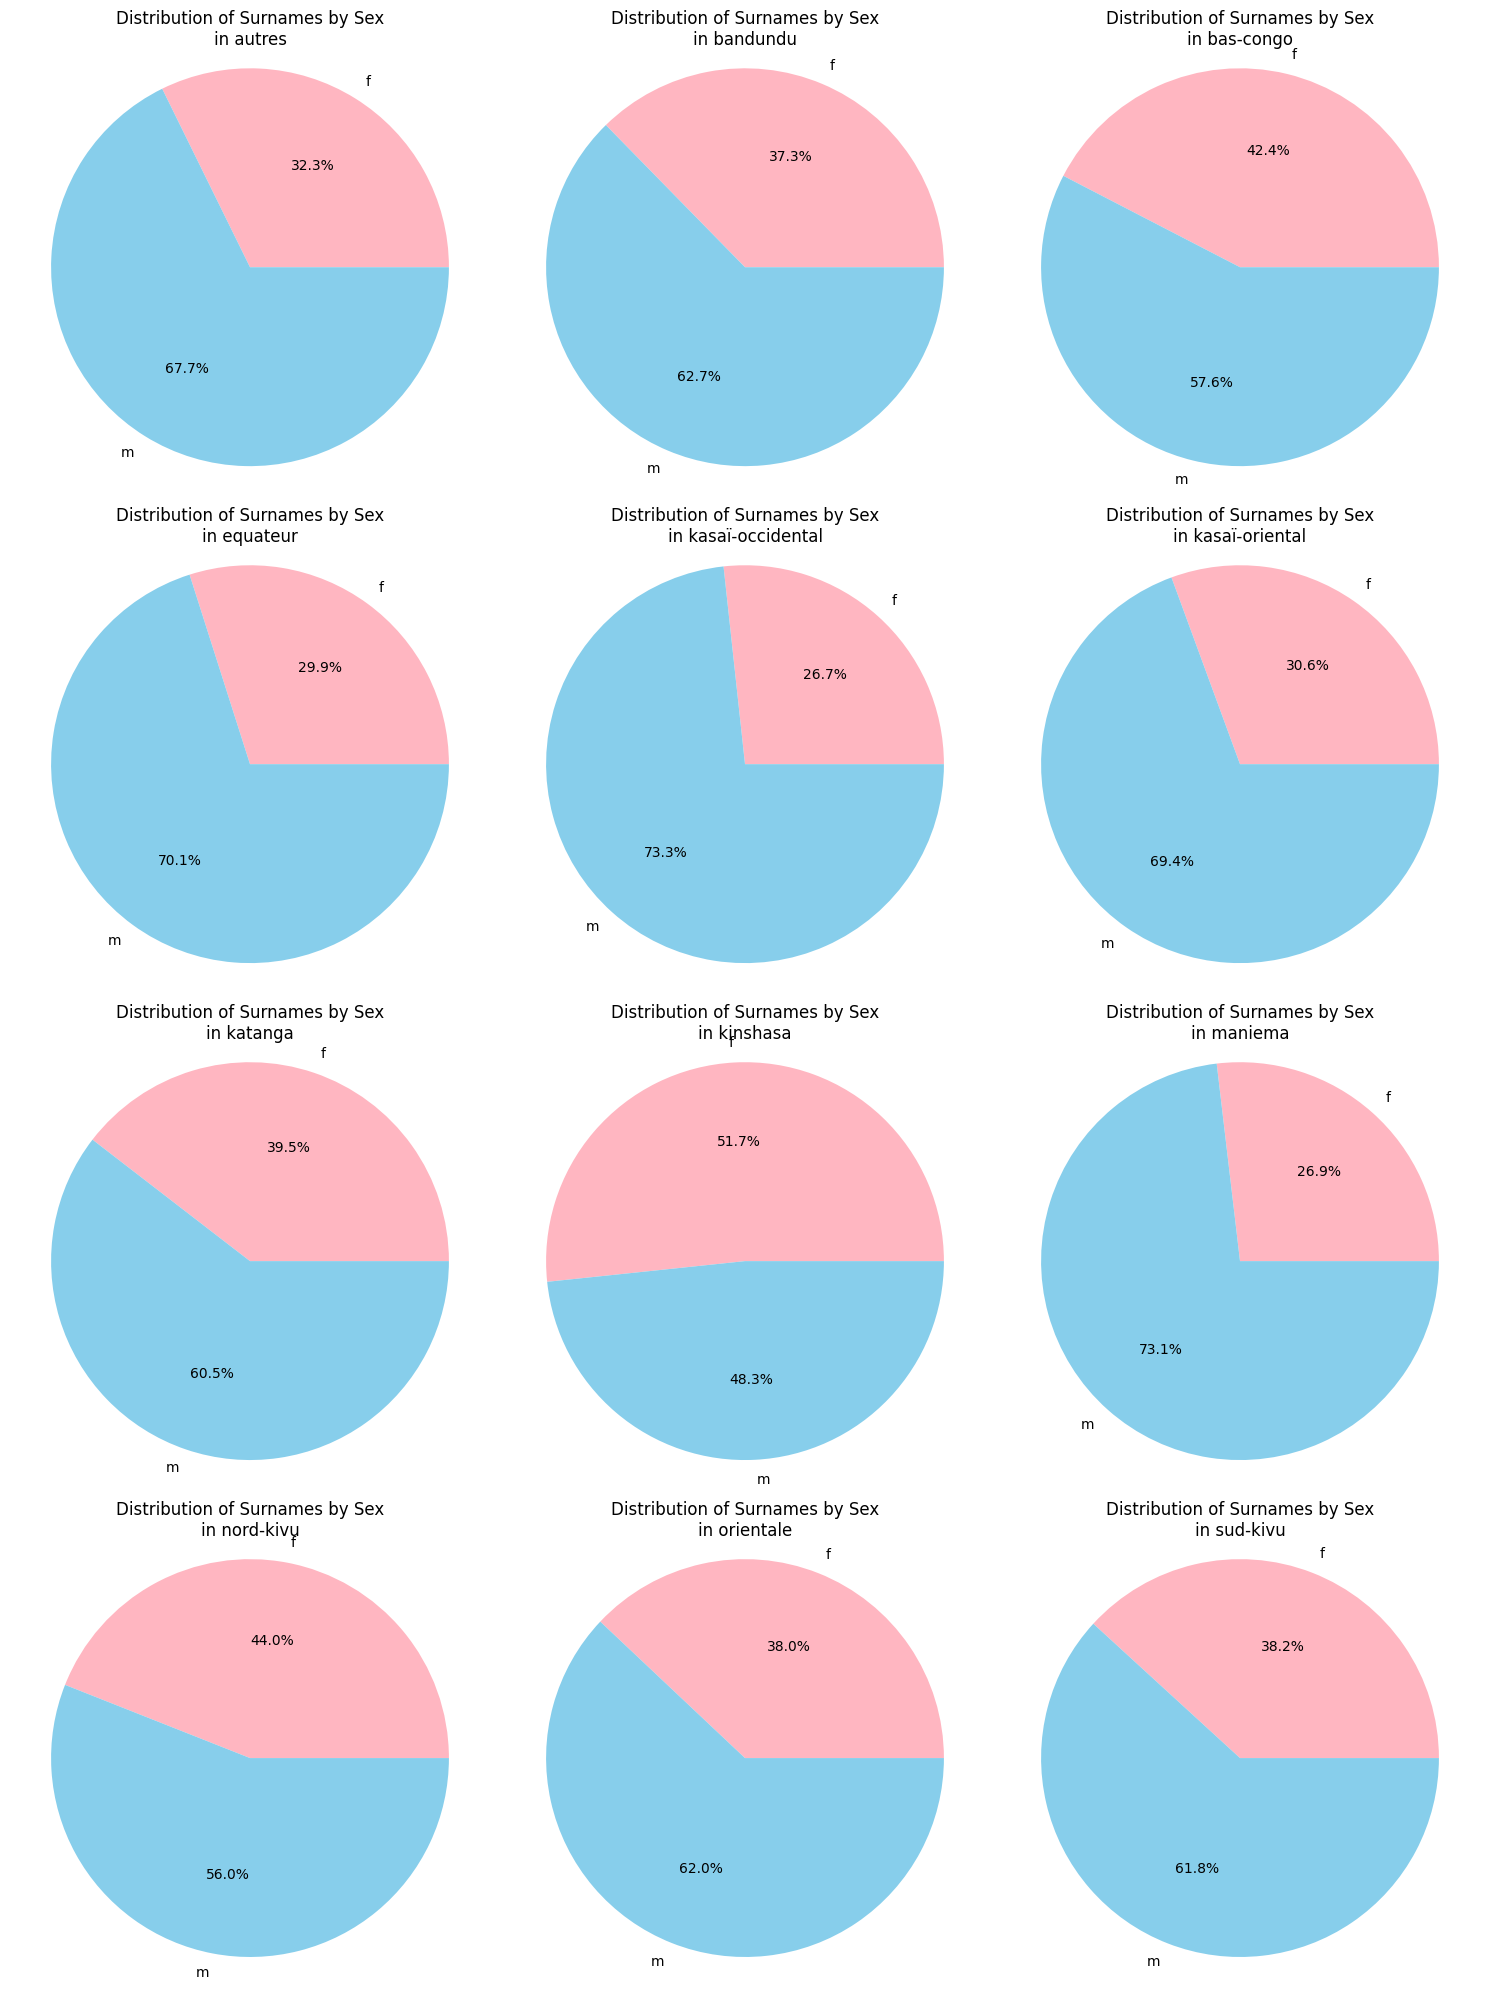

In [35]:
# Pie chart of surnames by sex and region
prov_sex_counts = (
    df_simple.groupby(["province", "sex"]).size().reset_index(name="count")
)
provinces = prov_sex_counts["province"].unique()
cols = 3
rows = (len(provinces) + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 5))
for i, prov in enumerate(provinces, 1):
    data = prov_sex_counts[prov_sex_counts["province"] == prov]
    plt.subplot(rows, cols, i)
    plt.pie(
        data["count"],
        labels=data["sex"],
        autopct="%1.1f%%",
        colors=["lightpink", "skyblue"],
    )
    plt.title(f"Distribution of Surnames by Sex\nin {prov}")
    plt.axis("equal")

plt.tight_layout()
plt.show()

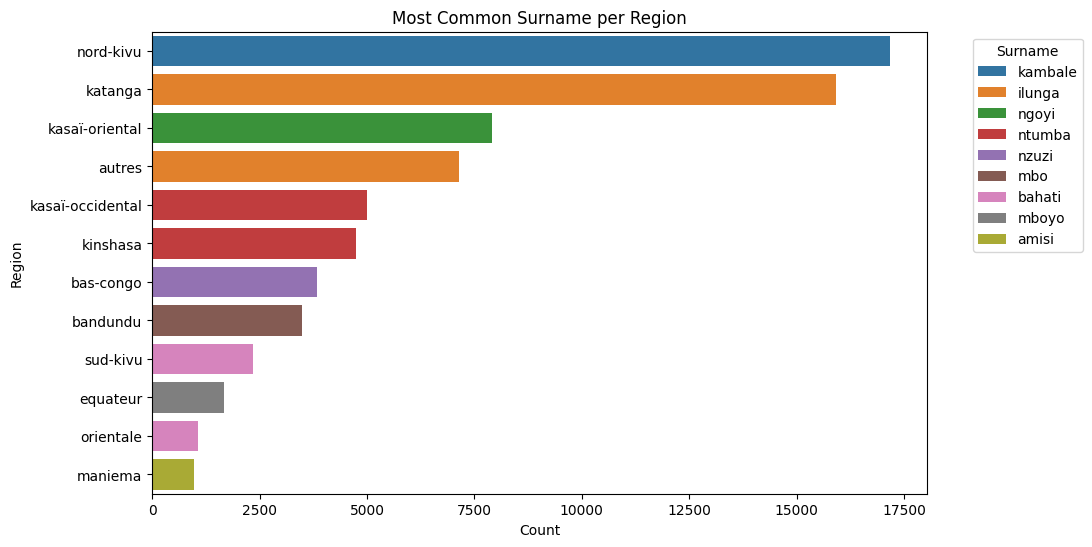

In [36]:
# surnames per region (aggregated)
top_surnames_region = (
    surnames_by_region.sort_values("count", ascending=False)
    .drop_duplicates("province")
    .head(12)
)
plt.figure(figsize=(10, 6))
sns.barplot(
    y="province", x="count", data=top_surnames_region, hue="surname", dodge=False
)
plt.title("Most Common Surname per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Surname", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

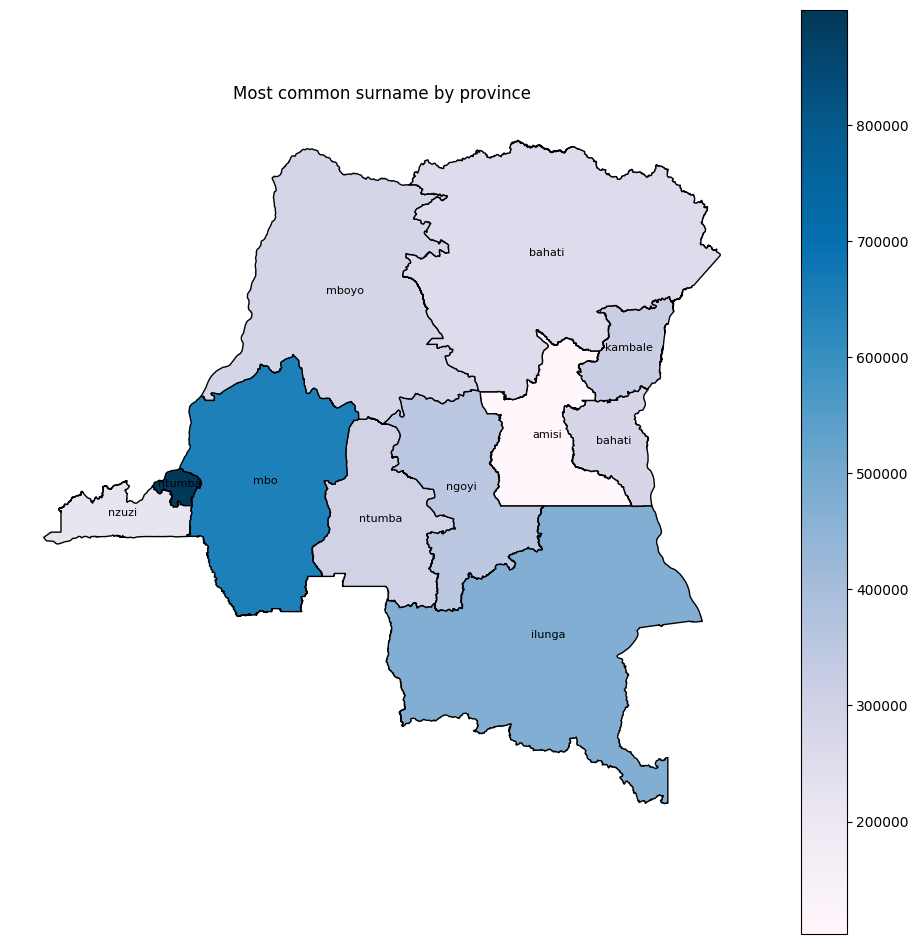

In [37]:
# Map of the most common surname by province in DRC
top_surnames = (
    df_simple.groupby(["province", "surname"]).size().reset_index(name="count")
)
top_surnames = top_surnames.sort_values(["province", "count"], ascending=[True, False])
top_surnames = top_surnames.drop_duplicates(subset="province", keep="first")
top_surnames["province_clean"] = (
    top_surnames["province"]
    .str.upper()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

gdf_named = gdf_merged.merge(
    top_surnames[["province_clean", "surname"]], on="province_clean", how="left"
)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column="count", cmap="PuBu", edgecolor="black", legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row["surname"]):
        centroid = row["geometry"].centroid
        plt.text(
            centroid.x,
            centroid.y,
            row["surname"],
            horizontalalignment="center",
            fontsize=8,
            color="black",
        )

plt.title("Most common surname by province")
plt.axis("off")
plt.show()

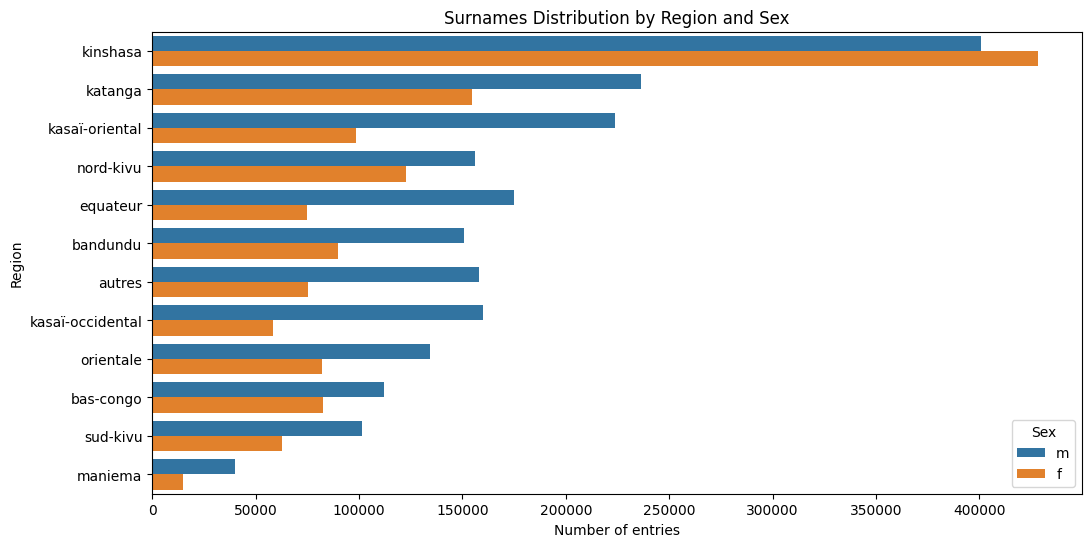

In [38]:
# Bar chart surnames by region and sex
top10_regions = df_simple["province"].value_counts().head(12).index.tolist()
df_top10 = df_simple[df_simple["province"].isin(top10_regions)]
plt.figure(figsize=(12, 6))
sns.countplot(data=df_top10, y="province", hue="sex", order=top10_regions)
plt.title("Surnames Distribution by Region and Sex")
plt.xlabel("Number of entries")
plt.ylabel("Region")
plt.legend(title="Sex")
plt.show()

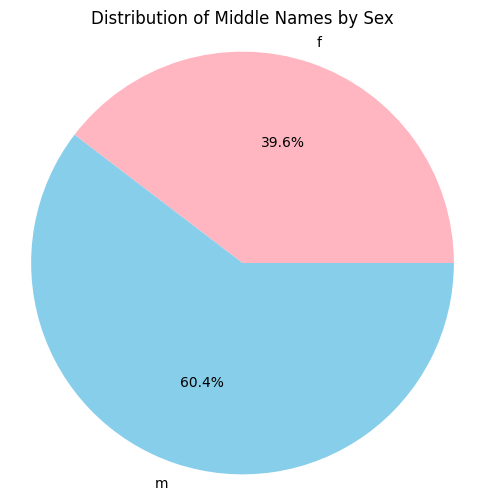

In [39]:
# Pie chart of middle names by sex
middlenames_sex_count = middlenames_by_province_sex.groupby("sex")["count"].sum()
plt.figure(figsize=(6, 6))
plt.pie(
    middlenames_sex_count,
    labels=middlenames_sex_count.index,
    autopct="%1.1f%%",
    colors=["lightpink", "skyblue"],
)
plt.title("Distribution of Middle Names by Sex")
plt.axis("equal")
plt.show()

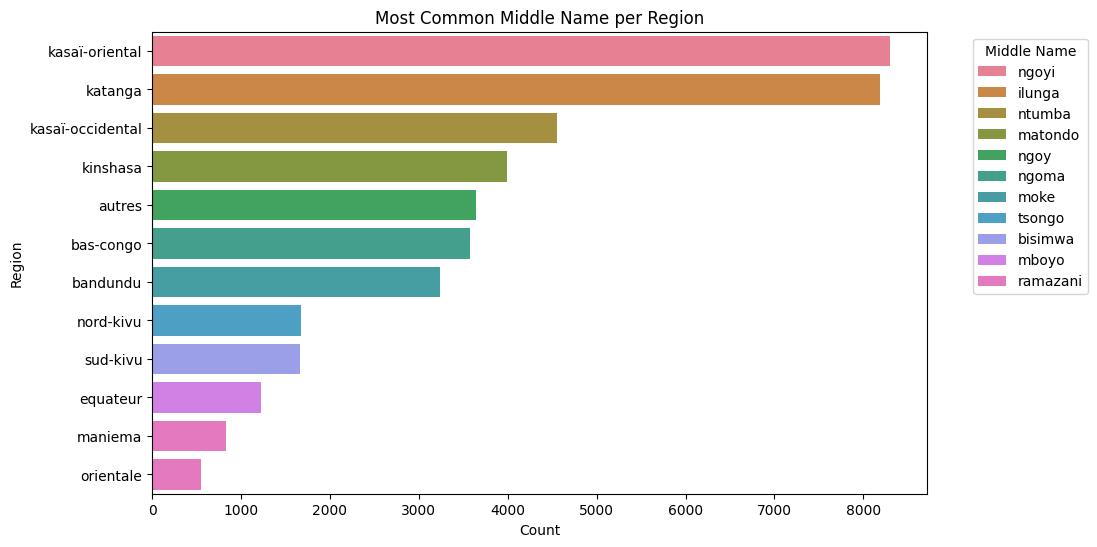

In [40]:
# most popular middle name per region
top_middlename_region = (
    middlenames_by_region.sort_values("count", ascending=False)
    .drop_duplicates("province")
    .head(12)
)
plt.figure(figsize=(10, 6))
sns.barplot(
    y="province", x="count", data=top_middlename_region, hue="middle_name", dodge=False
)
plt.title("Most Common Middle Name per Region")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Middle Name", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

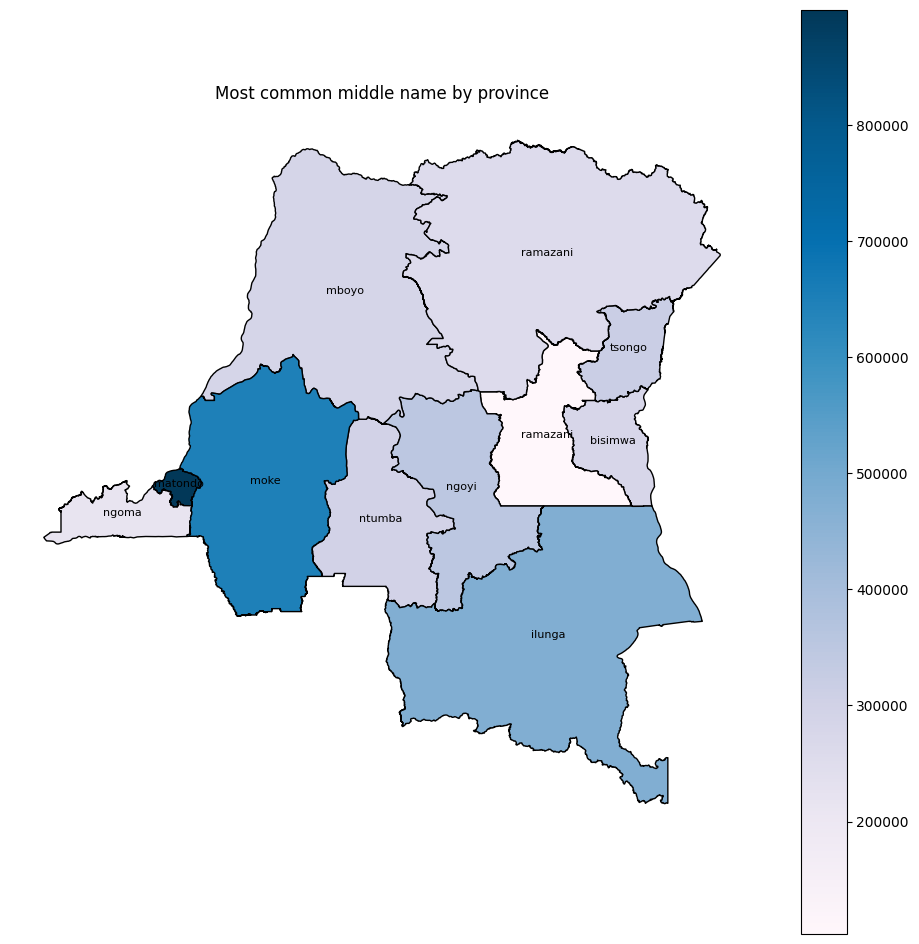

In [41]:
# Map of the most common middle by province in DRC
top_surnames = (
    df_simple.groupby(["province", "middle_name"]).size().reset_index(name="count")
)
top_surnames = top_surnames.sort_values(["province", "count"], ascending=[True, False])
top_surnames = top_surnames.drop_duplicates(subset="province", keep="first")
top_surnames["province_clean"] = (
    top_surnames["province"]
    .str.upper()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

gdf_named = gdf_merged.merge(
    top_surnames[["province_clean", "middle_name"]], on="province_clean", how="left"
)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_named.plot(column="count", cmap="PuBu", edgecolor="black", legend=True, ax=ax)

for idx, row in gdf_named.iterrows():
    if pd.notna(row["middle_name"]):
        centroid = row["geometry"].centroid
        plt.text(
            centroid.x,
            centroid.y,
            row["middle_name"],
            horizontalalignment="center",
            fontsize=8,
            color="black",
        )

plt.title("Most common middle name by province")
plt.axis("off")
plt.show()

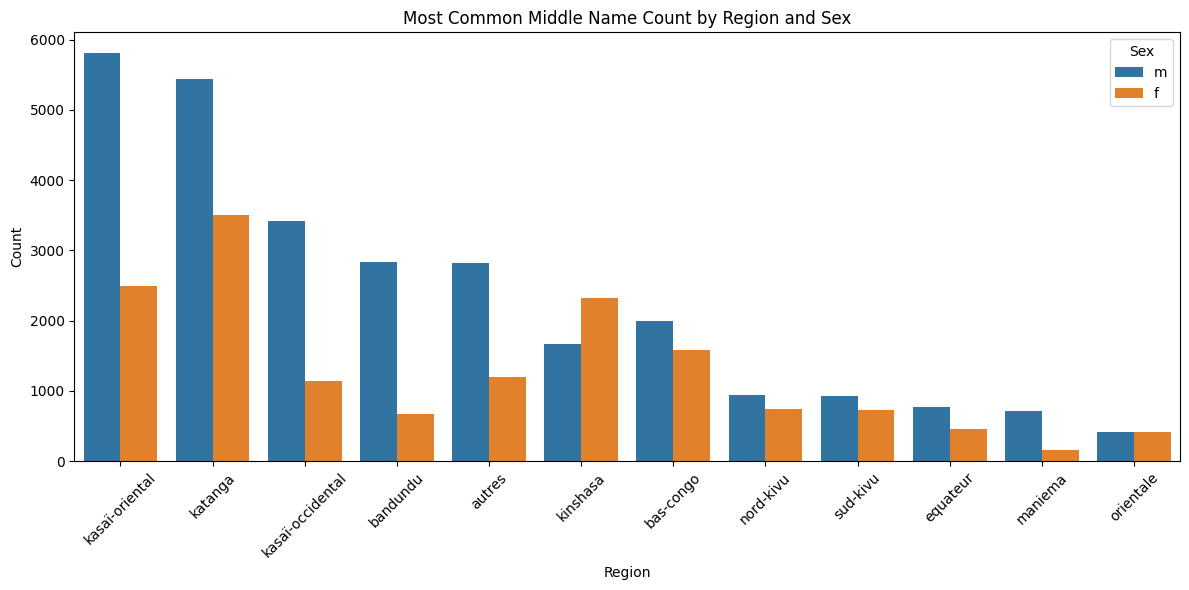

In [42]:
# Bar chart middle name by region and sex
middlenames_by_sex_region = (
    df_simple.groupby(["province", "sex", "middle_name"])
    .size()
    .reset_index(name="count")
)
top_middlename_sex_region = middlenames_by_sex_region.sort_values(
    "count", ascending=False
).drop_duplicates(["province", "sex"])

# Bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=top_middlename_sex_region, x="province", y="count", hue="sex")
plt.title("Most Common Middle Name Count by Region and Sex")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

In [43]:
# Crossover 1: Firstname vs Surname
crossover_firstname_surname = (
    df_simple.groupby(["first_name", "surname"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)
print("--- Top 10 Firstname vs Surname Crossovers ---")
print(crossover_firstname_surname)
print("\n")

--- Top 10 Firstname vs Surname Crossovers ---
first_name  surname
jean        ilunga     708
            ngoyi      521
            kasongo    514
rachel      kavira     430
jean        mbuyi      424
justin      kambale    396
jean        ntumba     393
            ngoy       391
neema       kavira     382
esther      kavira     382
dtype: int64




In [44]:
# Crossover: Firstname vs Surname vs Sex
crossover_fname_sname_sex = (
    df_simple.groupby(["sex", "first_name", "surname"]).size().reset_index(name="count")
)
crossover_fname_sname_sex = crossover_fname_sname_sex.sort_values(
    "count", ascending=False
).head(10)

print("--- Top 10 Firstname vs Surname Crossovers by Sex ---")
for sex, group in crossover_fname_sname_sex.groupby("sex"):
    print(f"\nSEX: {sex}")
    for _, row in group.iterrows():
        print(f"  {row['first_name']} {row['surname']} — {row['count']}")

--- Top 10 Firstname vs Surname Crossovers by Sex ---

SEX: f
  rachel kavira — 428
  neema kavira — 382
  esther kavira — 381

SEX: m
  jean ilunga — 707
  jean ngoyi — 521
  jean kasongo — 513
  jean mbuyi — 424
  justin kambale — 396
  jean ntumba — 393
  jean ngoy — 388


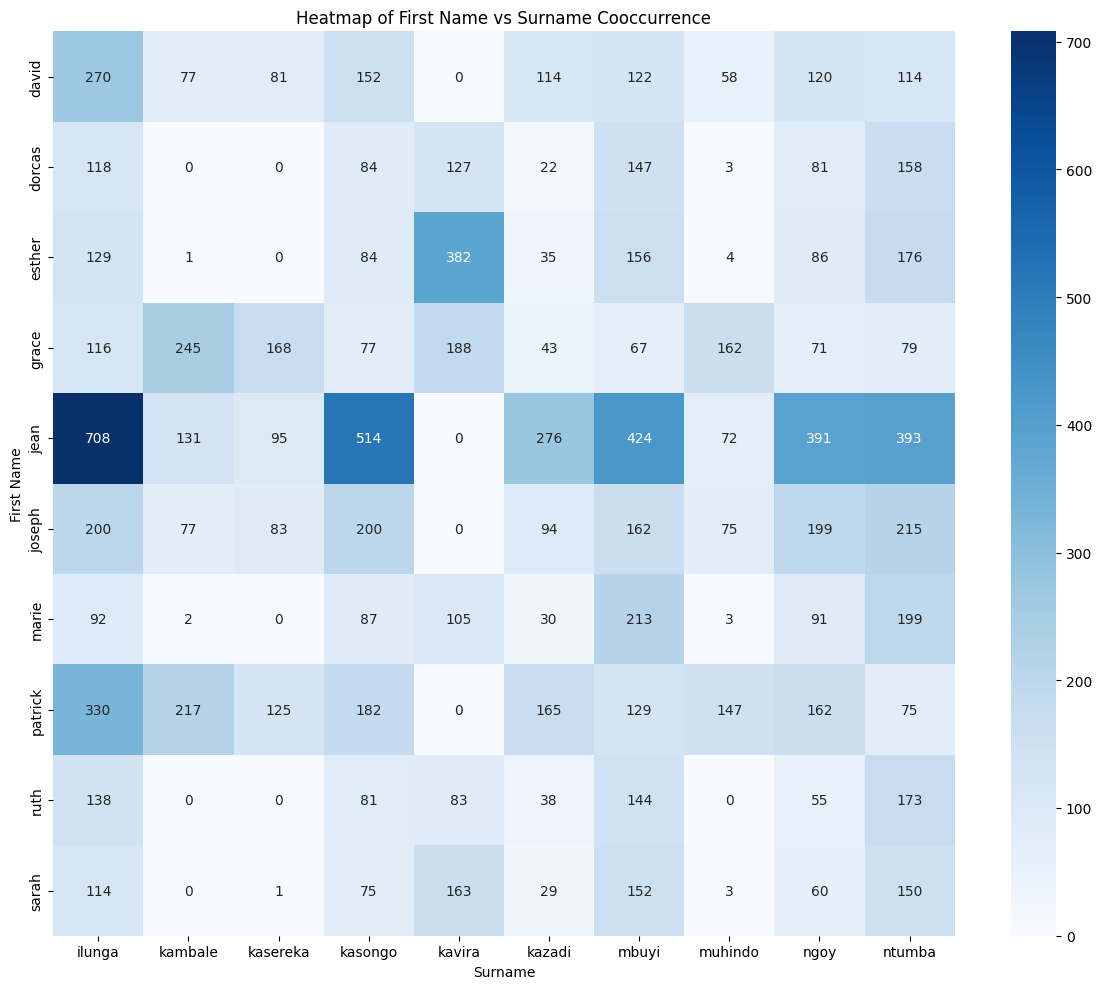

In [45]:
# frequency of joint appearance
top_firstnames = df_simple["first_name"].value_counts().head(10).index
top_surnames = df_simple["surname"].value_counts().head(10).index

filtered_df = df_simple[
    df_simple["first_name"].isin(top_firstnames)
    & df_simple["surname"].isin(top_surnames)
]

cooccurrence = (
    filtered_df.groupby(["first_name", "surname"]).size().unstack(fill_value=0)
)

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of First Name vs Surname Cooccurrence")
plt.xlabel("Surname")
plt.ylabel("First Name")
plt.tight_layout()
plt.show()

In [46]:
# Crossover 2: Firstname vs Middle Name
crossover_firstname_middlename = (
    df_simple.groupby(["first_name", "middle_name"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)
print("--- Top 10 Firstname vs Middle Name Crossovers ---")
print(crossover_firstname_middlename)
print("\n")

--- Top 10 Firstname vs Middle Name Crossovers ---
first_name  middle_name
jean        ilunga         493
            ngoyi          474
kasongo     wa             459
ilunga      wa             449
jean        kasongo        397
ngoy        ngoy           365
jean        ntumba         361
pierre      jean           341
paul        jean           329
ngoy        wa             322
dtype: int64




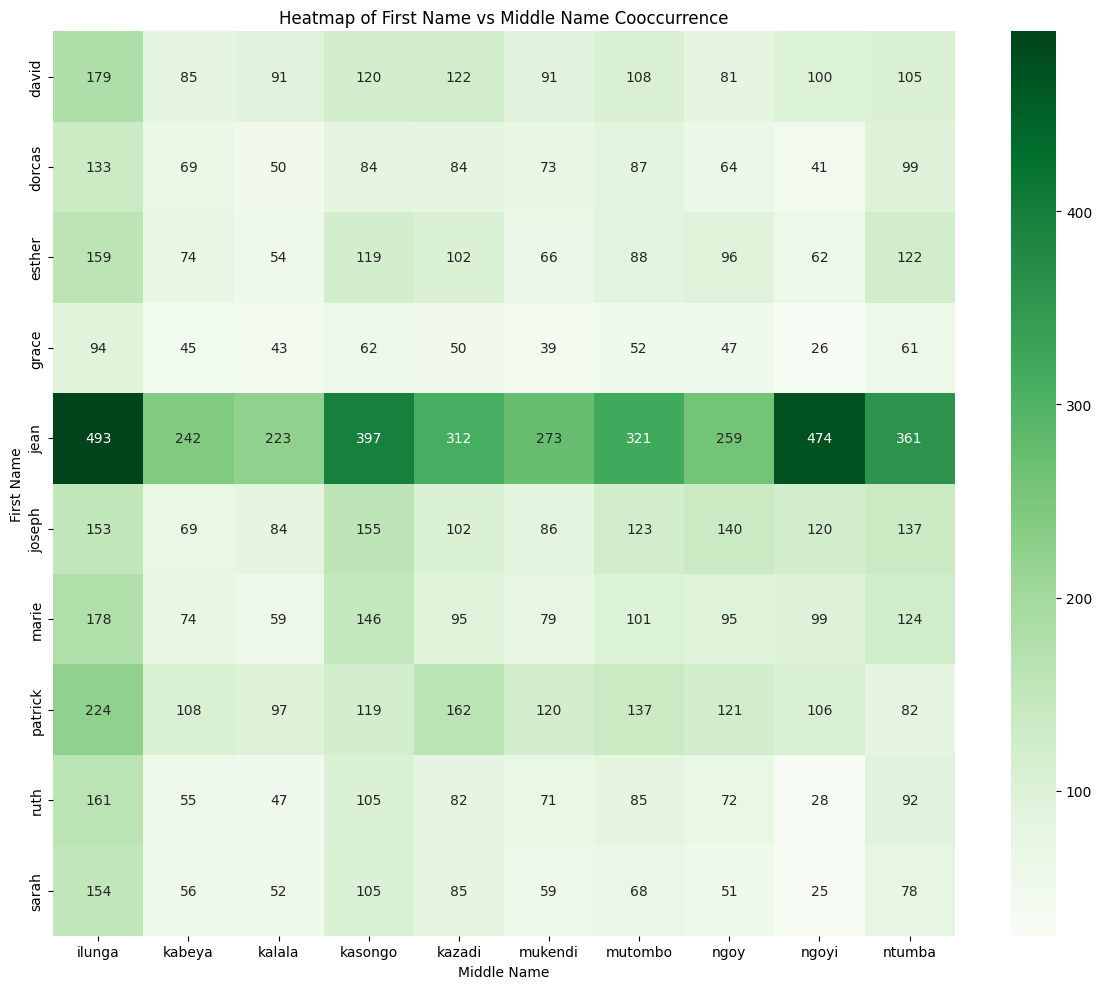

In [47]:
# frequency of joint appearance
top_middlenames = df_simple["middle_name"].value_counts().head(10).index

filtered_df = df_simple[
    df_simple["first_name"].isin(top_firstnames)
    & df_simple["middle_name"].isin(top_middlenames)
]

cooccurrence = (
    filtered_df.groupby(["first_name", "middle_name"]).size().unstack(fill_value=0)
)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="Greens")
plt.title("Heatmap of First Name vs Middle Name Cooccurrence")
plt.xlabel("Middle Name")
plt.ylabel("First Name")
plt.tight_layout()
plt.show()

In [48]:
# Crossover: Firstname vs Middle Name vs Sex
crossover_fname_middlename_sex = (
    df_simple.groupby(["sex", "first_name", "middle_name"])
    .size()
    .reset_index(name="count")
)
crossover_fname_middlename_sex = crossover_fname_middlename_sex.sort_values(
    "count", ascending=False
).head(10)

print("--- Top 10 Firstname vs Middle Name Crossovers by Sex ---")
for sex, group in crossover_fname_middlename_sex.groupby("sex"):
    print(f"\nSEX: {sex}")
    for _, row in group.iterrows():
        print(f"  {row['first_name']} {row['middle_name']} — {row['count']}")

--- Top 10 Firstname vs Middle Name Crossovers by Sex ---

SEX: m
  jean ilunga — 491
  jean ngoyi — 474
  jean kasongo — 396
  jean ntumba — 357
  pierre jean — 337
  kasongo wa — 337
  paul jean — 328
  jean mutombo — 321
  jean kazadi — 312
  ilunga wa — 295


In [49]:
# Crossover 3: Surname vs Middle Name
print("--- Top 10 Surname vs Middle Name Crossovers ---")
crossover_surname_middlename = (
    df_simple.groupby(["surname", "middle_name"])
    .size()
    .sort_values(ascending=False)
    .head(10)
)
print(crossover_surname_middlename)
print("\n")

--- Top 10 Surname vs Middle Name Crossovers ---
surname  middle_name
ilunga   ilunga         1173
         ngoy            964
ngoyi    ngoyi           885
kabange  numbi           830
ngoy     mwilambwe       707
kazadi   kazadi          663
ilunga   kasongo         633
kasongo  ilunga          597
ntumba   ntumba          585
kasongo  ngoy            575
dtype: int64




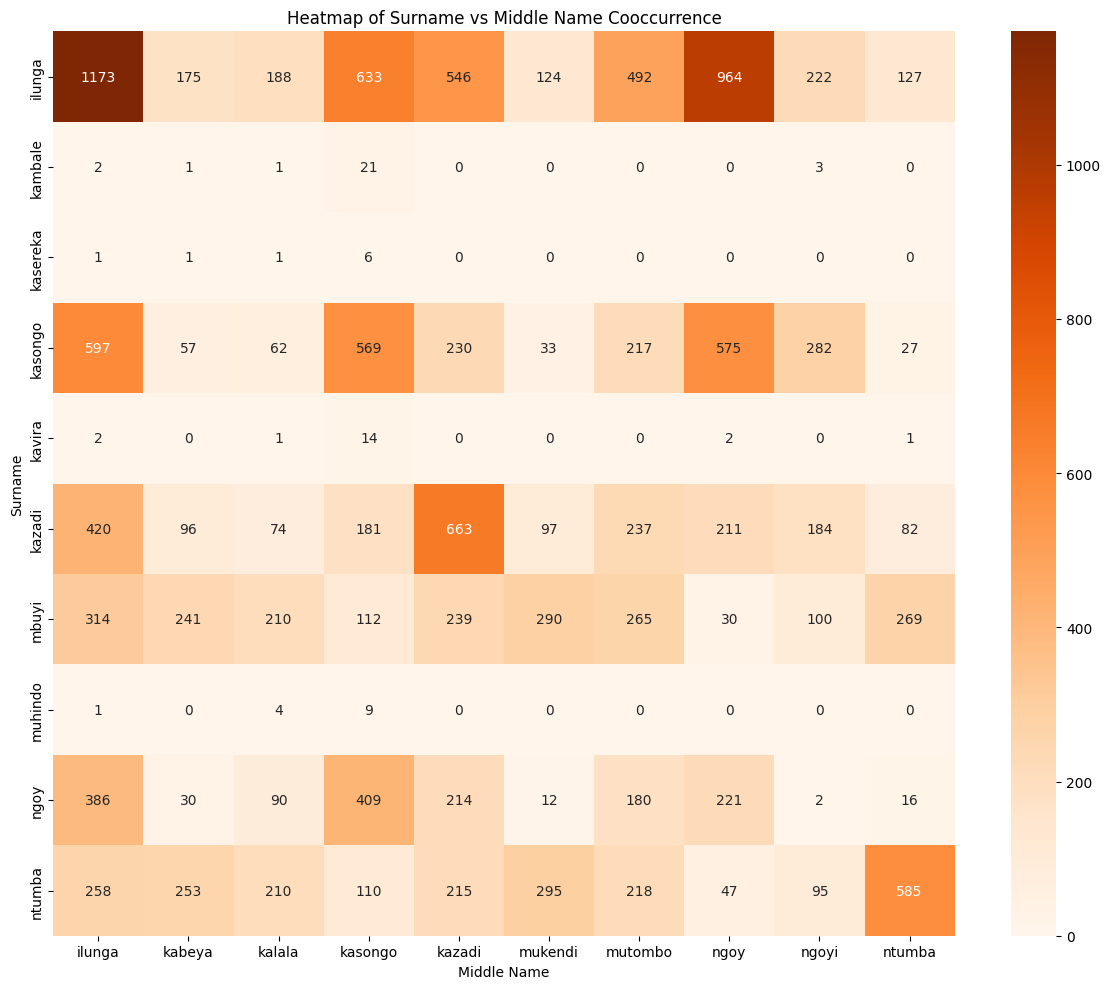

In [50]:
# frequency of joint appearance
top_surnames = df_simple["surname"].value_counts().head(10).index
top_middlenames = df_simple["middle_name"].value_counts().head(10).index
filtered_df = df_simple[
    df_simple["surname"].isin(top_surnames)
    & df_simple["middle_name"].isin(top_middlenames)
]

cooccurrence = (
    filtered_df.groupby(["surname", "middle_name"]).size().unstack(fill_value=0)
)

plt.figure(figsize=(12, 10))
sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="Oranges")
plt.title("Heatmap of Surname vs Middle Name Cooccurrence")
plt.xlabel("Middle Name")
plt.ylabel("Surname")
plt.tight_layout()
plt.show()

In [51]:
# Crossover: Surname vs Middle Name vs Sex
crossover_surname_middlename_sex = (
    df_simple.groupby(["sex", "surname", "middle_name"])
    .size()
    .reset_index(name="count")
)
crossover_surname_middlename_sex = crossover_surname_middlename_sex.sort_values(
    "count", ascending=False
).head(10)

print("--- Top 10 Surname vs Middle Name Crossovers by Sex ---")
for sex, group in crossover_surname_middlename_sex.groupby("sex"):
    print(f"\nSEX: {sex}")
    for _, row in group.iterrows():
        print(f"  {row['surname']} {row['middle_name']} — {row['count']}")

--- Top 10 Surname vs Middle Name Crossovers by Sex ---

SEX: m
  ilunga ilunga — 1095
  ngoyi ngoyi — 752
  kazadi kazadi — 626
  kabange numbi — 587
  ilunga ngoy — 583
  mutombo mutombo — 538
  ngoy mwilambwe — 528
  mukendi mukendi — 512
  kasongo kasongo — 492
  kabeya kabeya — 489


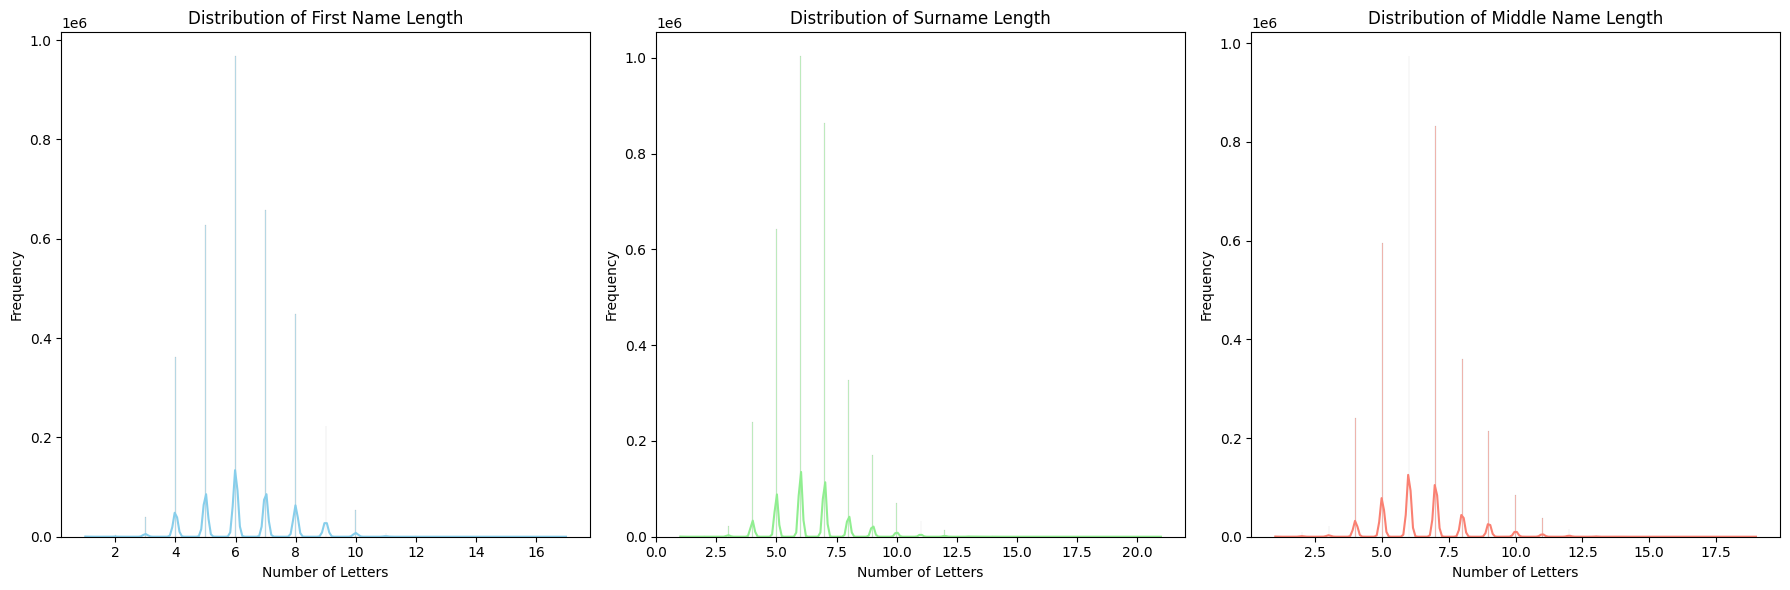

In [52]:
# Calculate the length of first names, surnames, and middle names
df["firstname_length"] = df_simple["first_name"].str.len()
df["surname_length"] = df_simple["surname"].str.len()
df["middlename_length"] = df_simple["middle_name"].str.len()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram for firstname length
sns.histplot(df["firstname_length"], kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of First Name Length")
axes[0].set_xlabel("Number of Letters")
axes[0].set_ylabel("Frequency")

# Histogram for surname length
sns.histplot(df["surname_length"], kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("Distribution of Surname Length")
axes[1].set_xlabel("Number of Letters")
axes[1].set_ylabel("Frequency")

# Histogram for middle name length
sns.histplot(df["middlename_length"], kde=True, ax=axes[2], color="salmon")
axes[2].set_title("Distribution of Middle Name Length")
axes[2].set_xlabel("Number of Letters")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()